In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.options.display.float_format = '{:.5f}'.format
pd.options.mode.chained_assignment = None

# 1. Dataset

Vamos a trabajar con el dataset de estadísticas de la NBA.

El dataset contiene las siguientes variables:

* **player**: nombre del jugador
* **position**: posicion que juega el jugador
* **age**: edad
* **team_id**: equipo
* **g**: cantidad de partidos jugados
* **mp_per_g**: minutos por partido
* **trb_per_g**: rebotes por partido
* **ast_per_g**: asistencias por partido
* **stl_per_g**:robos por partido
* **blk_per_g**:tapas/bloqueos por partido
* **pts_per_g**:puntos por partido

In [9]:
# Cargamos el dataset desde el link
#nba = pd.read_csv('/content/drive/MyDrive/Curso CPE Data Wrangling/Clases/datasets/estadisticas_nba.csv')
nba = pd.read_csv('./sample_data/estadisticas_nba.csv')

# Vemos 10 registros al azar
nba.sample(10)

,player,position,age,team_id,g,mp_per_g,trb_per_g,ast_per_g,stl_per_g,blk_per_g,pts_per_g
13,Kostas Antetokounmpo,PF,22,LAL,5,4.00000,0.60000,0.40000,0.00000,0.00000,1.40000
419,Naz Reid,C,20,MIN,30,16.50000,4.10000,1.20000,0.60000,0.70000,9.00000
393,Patrick Patterson,PF,30,LAC,59,13.20000,2.60000,0.70000,0.10000,0.10000,4.90000
130,Gorgui Dieng,C,30,TOT,63,17.40000,5.60000,1.20000,0.80000,0.90000,7.40000
184,Danny Green,SG,32,LAL,68,24.80000,3.30000,1.30000,1.30000,0.50000,8.00000
454,Dennis Smith Jr.,PG,22,NYK,34,15.80000,2.30000,2.90000,0.80000,0.20000,5.50000
135,Damyean Dotson,SG,25,NYK,48,17.40000,1.90000,1.20000,0.50000,0.10000,6.70000
211,Dewan Hernandez,C,23,TOR,6,4.70000,2.30000,0.50000,0.20000,0.00000,2.30000
277,Furkan Korkmaz,SG,22,PHI,72,21.70000,2.30000,1.10000,0.60000,0.20000,9.80000
263,Tyus Jones,PG,23,MEM,65,19.00000,1.60000,4.40000,0.90000,0.10000,7.40000


# 2. Objetivo: detectar jugadores fuera de serie

Llega el momento de armar los ranking de los jugadores destacados en los rubros de minutos jugados, rebotes, asistencias, robos, bloqueos y puntos por partido. 

Consideremos que un jugador se puede destacar por tener estadísticas mucho mejores o mucho peores en el rubro.

Para ello, vamos a tratar de detectar los outliers en estos rubros

## 2.1 Escala de las variables

Evaluemos la escala de las variables y su distribución

Primero, observemos los estadísticos descriptivos de las variables

In [10]:
nba.describe()

,age,g,mp_per_g,trb_per_g,ast_per_g,stl_per_g,blk_per_g,pts_per_g
count,529.00000,529.00000,529.00000,529.00000,529.00000,529.00000,529.00000,529.00000
mean,25.56144,42.33081,19.51304,3.63270,1.92363,0.62193,0.39905,8.72647
std,4.11949,22.63332,9.21021,2.48097,1.76254,0.40280,0.41187,6.36797
min,19.00000,1.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000
25%,22.00000,22.00000,12.00000,1.90000,0.80000,0.30000,0.10000,3.90000
50%,25.00000,48.00000,18.90000,3.20000,1.40000,0.60000,0.30000,7.00000
75%,28.00000,62.00000,27.80000,4.70000,2.40000,0.90000,0.50000,11.90000
max,43.00000,74.00000,37.50000,15.20000,10.20000,2.10000,2.90000,34.30000


¿Qué observamos con estos datos?

Las variables son todas no negativas pero como se refieren a atributos distintos se encuentran medidas en unidades distintas.

# 3 Detección de outliers univariados

El método para detectar outliers que hemos visto consiste en estandarizar la variable y catalogar como outlier a aquellas observaciones cuyo z-score que superen, en valor absoluto, un límite (usualmente de 3).

Entonces el primer paso será estandarizar las variables con la fórmula:

$ x_e = \frac{x-\overline{X}}{\sigma_X}$


In [11]:
# Funcion para estandarizar
def estandarizar_var(X):
  promedio = np.mean(X)
  desvio = np.std(X)
  X_estandarizada = (X-promedio)/desvio
  return X_estandarizada

In [12]:
# Variables relevantes
lista_variables = ["mp_per_g", "trb_per_g", "ast_per_g", "stl_per_g", "blk_per_g", "pts_per_g"]

In [13]:
#Podemos aplicar la función sobre las variables con la función apply
nba_estandarizadas = nba.loc[:,lista_variables].apply(estandarizar_var)
nba_estandarizadas['jugador'] = nba.player
nba_estandarizadas.head()

,mp_per_g,trb_per_g,ast_per_g,stl_per_g,blk_per_g,pts_per_g,jugador
0,0.78106,2.28647,0.21374,0.44251,1.70346,0.34165,Steven Adams
1,1.53094,2.64958,1.80386,1.18800,2.18951,1.12757,Bam Adebayo
2,1.47660,1.51992,0.27053,0.19401,2.91858,1.59912,LaMarcus Aldridge
3,-1.41423,-0.86044,-1.09243,-1.54548,-0.96980,-1.21448,Kyle Alexander
4,-0.75129,-0.73940,-0.01342,-0.55149,-0.48375,-0.47571,Nickeil Alexander-Walker


## 3.1 Gráficos

Podemos observar los histogramas de las variables estandarizadas para poder detectar la existencia de outliers de manera fácil.

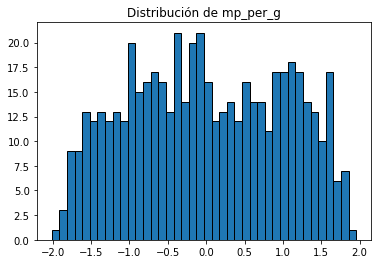

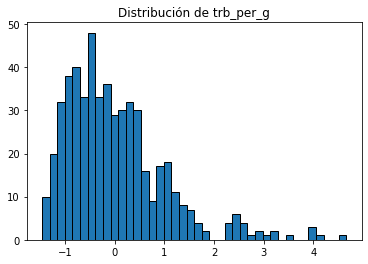

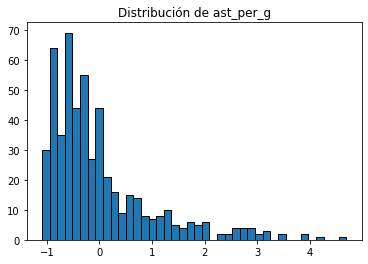

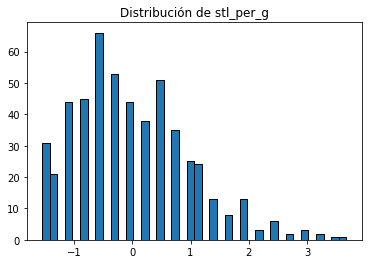

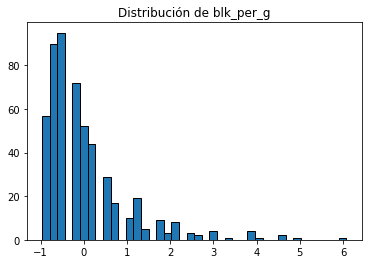

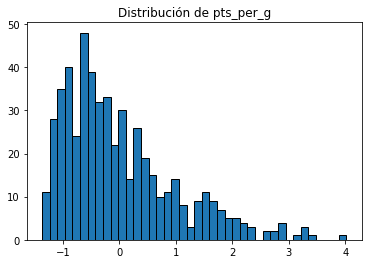

In [14]:
# Realizamos un loop sobre las variables
for variable in lista_variables:
  # Histograma de la variable
  plt.hist(nba_estandarizadas[variable], bins=40, ec='black')
  # Titulo del gráfico
  plt.title(f"Distribución de {variable}")
  plt.show()

¿Qué observamos en estos gráficos?

* Si tomamos un valor límite de 3, la variable de **Minutos por partido** no presenta outliers mientras que el resto presentan outliers.

* En la variable de **Bloqueos por partido** se observan algunos outliers muy marcados

* Tomando un valor límite de 3, no existen outliers negativos en estas variables

## 3.2 Criterio analitico

Ahora diseñemos una función que nos permita detectar estos outliers de manera analitica.

Esta función debe devolver la lista de los jugadores destacados para una variable y para un valor límite dado.

Vamos a utilizar la función `np.abs()` para calcular el valor absoluto de la variable estandarizada

In [15]:
# Función para detectar outliers
def detectar_jugadores_outliers(df_estandarizado, valor_limite, variable):
  jugadores_outliers = df_estandarizado.loc[np.abs(df_estandarizado[variable])>valor_limite, 'jugador'].to_list()
  return jugadores_outliers

In [16]:
# Detectamos jugadores que destaquen en rebotes
detectar_jugadores_outliers(nba_estandarizadas, 3, 'trb_per_g')

['Giannis Antetokounmpo',
 'Deandre Ayton',
 'Clint Capela',
 'Andre Drummond',
 'Joel Embiid',
 'Rudy Gobert',
 'Domantas Sabonis',
 'Jonas Valančiūnas',
 'Hassan Whiteside']

Para mejorar un poco más la interpretación podemos crear una función que nos devuelva al jugador con su estadística correspondiente en la variable

In [17]:
def detectar_jugadores_outliers_estadisticas(df, df_estandarizado, valor_limite, variable):
  jugadores_outliers = detectar_jugadores_outliers(df_estandarizado, valor_limite, variable)
  df_destacados = df.loc[df['player'].isin(jugadores_outliers), ['player',variable]]
  return df_destacados

In [18]:
# Detectamos jugadores que destaquen en rebotes con su estadistica
detectar_jugadores_outliers_estadisticas(nba, nba_estandarizadas, 3, 'trb_per_g')

,player,trb_per_g
12,Giannis Antetokounmpo,13.60000
20,Deandre Ayton,11.50000
86,Clint Capela,13.80000
139,Andre Drummond,15.20000
145,Joel Embiid,11.60000
175,Rudy Gobert,13.50000
435,Domantas Sabonis,12.40000
484,Jonas Valančiūnas,11.30000
508,Hassan Whiteside,13.50000


In [19]:
# Detectamos jugadores que destaquen en puntos con su estadistica
detectar_jugadores_outliers_estadisticas(nba, nba_estandarizadas, 3, 'pts_per_g')

,player,pts_per_g
12,Giannis Antetokounmpo,29.50000
34,Bradley Beal,30.50000
133,Luka Dončić,28.80000
197,James Harden,34.30000
296,Damian Lillard,30.00000
524,Trae Young,29.60000


# 4. Detección outliers multivariados

Observemos la relación entre los puntos por partido y las asistencias por partido (ambas variables se encuentran estandarizadas)

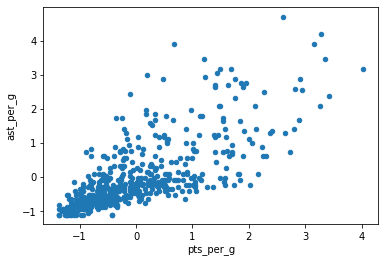

In [20]:
# Gráfico de dispersión de las variables
nba_estandarizadas.plot.scatter(x='pts_per_g', y='ast_per_g')
plt.show()

Marcamos los límites en los cuales consideramos que una observación es un outlier

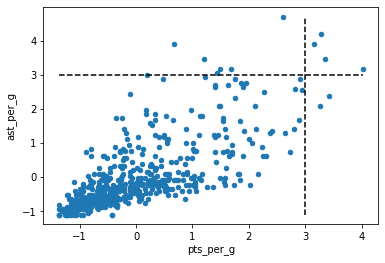

In [21]:
nba_estandarizadas.plot.scatter(x='pts_per_g', y='ast_per_g')
plt.vlines(x=3, ymin=nba_estandarizadas.ast_per_g.min(), ymax=nba_estandarizadas.ast_per_g.max(), linestyles='dashed')
plt.hlines(y=3, xmin=nba_estandarizadas.pts_per_g.min(), xmax=nba_estandarizadas.pts_per_g.max(), linestyles='dashed')
plt.show()

Quedan definadas cuatro regiones:

1. En la región inferior izquierda se encuentras las observaciones que no son outliers para ninguna variable
2. En la región superior derecha se encuentran las observaciones que son outliers para ambas variables
3. En la región superior izquierda se encuentran las observaciones que son outliers en asistencias
4. En la región inferior derecha se encuentran las observaciones que son outliers en puntos 



In [22]:
# Jugadores con outliers en ambas variables
nba_estandarizadas.query("pts_per_g > 3 & ast_per_g > 3")['jugador']

133       Luka Dončić
197      James Harden
296    Damian Lillard
524        Trae Young
Name: jugador, dtype: object

In [23]:
# Jugadores con outliers de puntos
nba_estandarizadas.query("pts_per_g > 3 & ast_per_g < 3")['jugador']

12    Giannis Antetokounmpo
34             Bradley Beal
Name: jugador, dtype: object

In [24]:
# Jugadores con outliers de asistencia
nba_estandarizadas.query("pts_per_g < 3 & ast_per_g > 3")['jugador']

179    Devonte' Graham
249       LeBron James
302         Kyle Lowry
348          Ja Morant
433        Ricky Rubio
450        Ben Simmons
Name: jugador, dtype: object